In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm
import patsy as pt
sns.set_theme(
    context='notebook',
    palette='viridis',
)

# PARTE 1 - Tratamento de dados

## Etapa 1 - Carregamento de dados

In [2]:
# Carregando o dataset
df_raw = pd.read_csv('50_startups.csv')

# Printando as primeiras 5 linhas
df_raw.head(5)

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


### <u>Conteúdo do dataset</u>

**R&D Spend** - Gastos com pesquisa e desenvolvimento (Research & Development);<br>
**Admnistration** - Gastos admnistrativos;<br>
**Marketing Spend** - Gastos com marketing;<br>
**State** - Estado da startup;<br>
**Profit** - Lucros com a startup, considerada a variável target.

*obs: dados relacionados a dinheiro, provavelmente em USD (United State Dollar)*



In [3]:
# Verificando os estados disponíveis no dataset
df_raw['State'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [4]:
# Verificando tipo dos dados
df_raw.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

## Etapa 2 - EDA e Análise Gráfica

In [5]:
# Verificando informações do dataset
df_raw.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


#### Verificando a distribuição dos dados

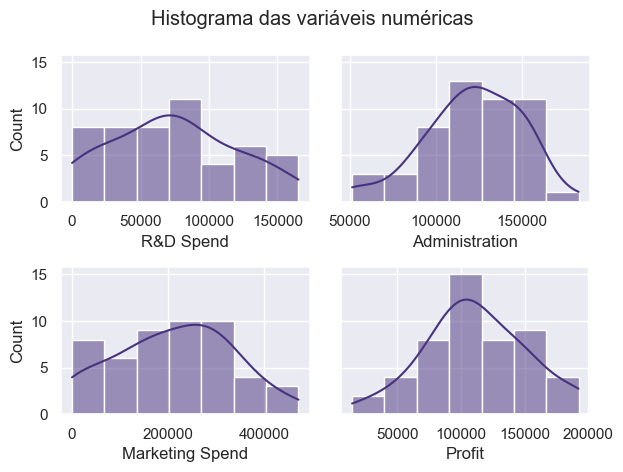

In [6]:
# Plotando histogramas 
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(6.4, 4.8))
axes = axes.flatten()
for col, ax in zip(df_raw.select_dtypes('number'), axes):
    sns.histplot(data=df_raw, x=col, ax=ax, kde=True)
fig.suptitle('Histograma das variáveis numéricas')
fig.tight_layout()
plt.show()

(array([0, 1, 2]),
 [Text(0, 0, 'New York'), Text(1, 0, 'California'), Text(2, 0, 'Florida')])

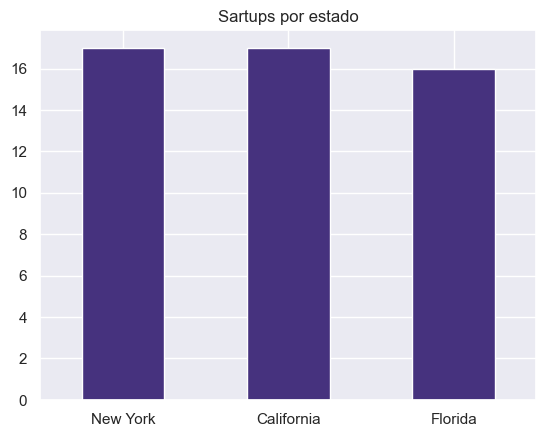

In [7]:
# Plotando a distribuição de estados
df_raw['State'].value_counts().plot.bar()
plt.title('Sartups por estado')
plt.xticks(rotation=0)

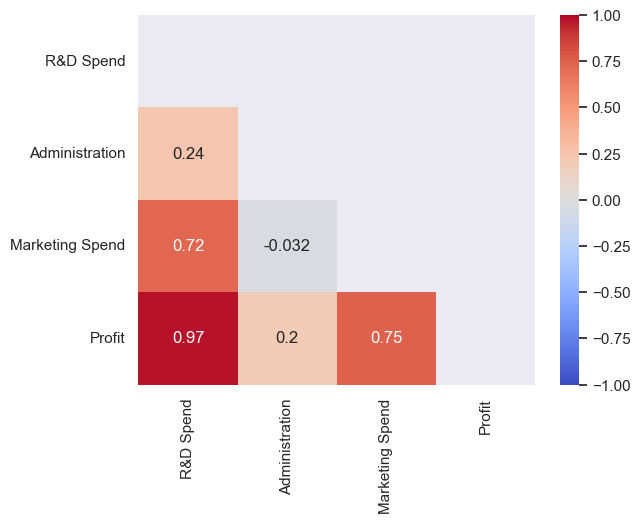

In [8]:
# Plotando correlograma
corr = df_raw.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    vmin=-1, vmax=1
);

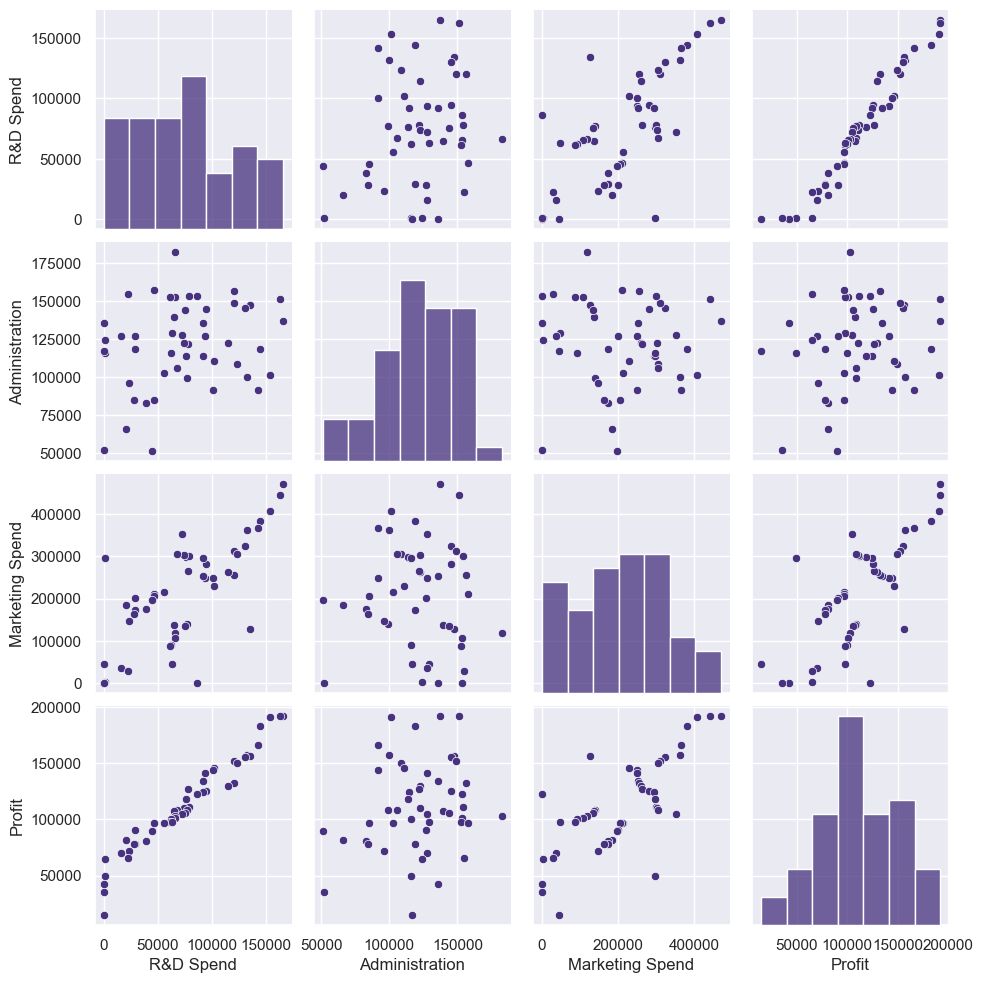

In [9]:
# Pairplot
sns.pairplot(df_raw)

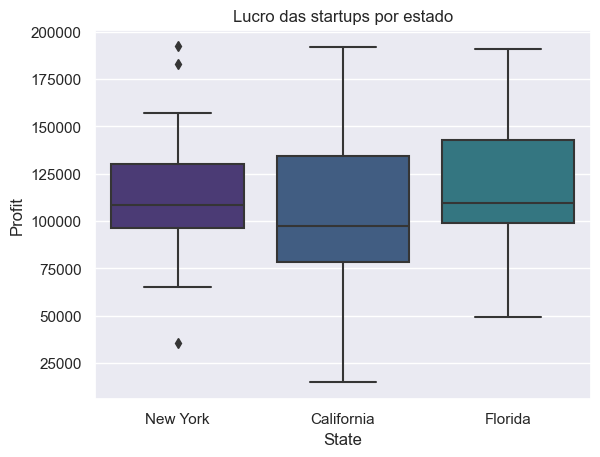

In [10]:
# Plotando boxplot c/ lucro das startups por estado
sns.boxplot(data=df_raw, x='State', y='Profit')
plt.title('Lucro das startups por estado');

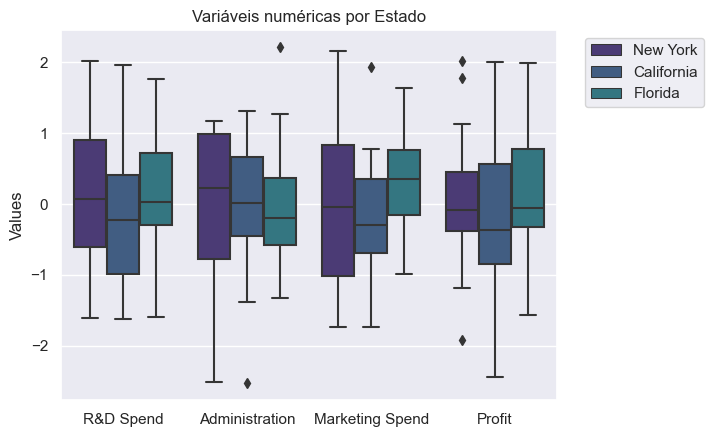

In [11]:
# Plotando boxplots separadas por estado
data = df_raw.copy()
num_cols = df_raw.select_dtypes('number').columns.to_list()
data[num_cols] = data[num_cols].apply(preprocessing.scale)

sns.boxplot(
    data=data.melt(id_vars=['State'], value_vars=num_cols,
                 var_name='States', value_name='Values'),
    x='States',
    y='Values',
    hue='State',
)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Variáveis numéricas por Estado')
plt.xlabel('')
plt.show()

## Etapa 3 - Pré-Processamento de Dados

In [12]:
# Plotando os tipos dos dados
df_raw.dtypes

R&D Spend          float64
Administration     float64
Marketing Spend    float64
State               object
Profit             float64
dtype: object

### <u>Classificação das variáveis</u>
**R&D Spend** - Custo com pesquisa e desenvolvimento (Research & Development), variável numérica contínua;<br>
**Administration** - Custos administrativos, variável numérica contínua;<br>
**State** - Estados das startups, variável categórica;<br>
**Profit** - Variável resposta do tipo numérica contínua.

In [13]:
# Separando o dataframe em variáveis regressoras e resposta
X = df_raw.iloc[:,:-1].copy()
y = df_raw.iloc[:,-1]

# Aplicando escalonamento nas variáveis numéricas
num_cols = X.select_dtypes('number').columns
X[num_cols] = X[num_cols].apply(preprocessing.scale)

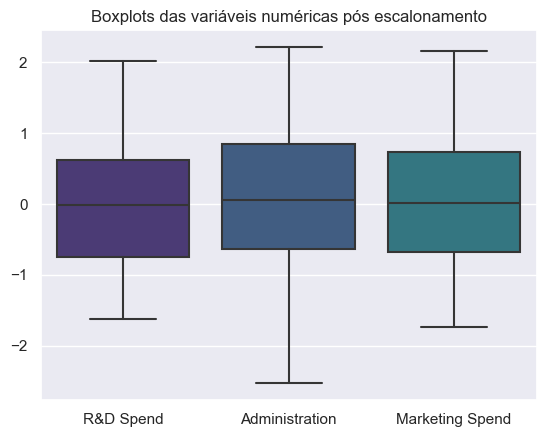

In [14]:
# Plotando boxplots das variáveis numéricas pós escalonamento
sns.boxplot(data=X)
plt.title('Boxplots das variáveis numéricas pós escalonamento');

In [15]:
# Alterando o tipo da coluna State para Category
X['State'] = X['State'].astype('category')

# Aplicando OnehotEncoder na coluna categórica Estado
cat_cols = X.select_dtypes(exclude='number').columns
df_cat = pd.get_dummies(X[cat_cols])

# Concatenando os dataframes
X = pd.concat([X[num_cols], df_cat], axis=1)

### <u>Avaliando as variáveis de resposta</u>

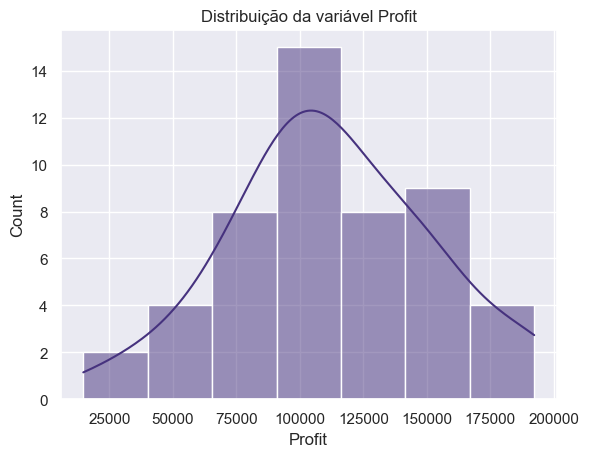

In [16]:
# Distribuição da resposta
plt.title('Distribuição da variável Profit')
sns.histplot(y, kde=True);

In [17]:
# Analise de normalidade pelo método Shapiro-Wilk
print(stats.shapiro(y))

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.anderson(y)}')

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.kstest(y, cdf="norm")}')

ShapiroResult(statistic=0.9848828911781311, pvalue=0.7665575742721558)

AndersonResult(statistic=0.24093459597249733, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

KstestResult(statistic=1.0, pvalue=0.0)


<AxesSubplot:title={'center':'Boxplot do lucro das startups'}, ylabel='Profit'>

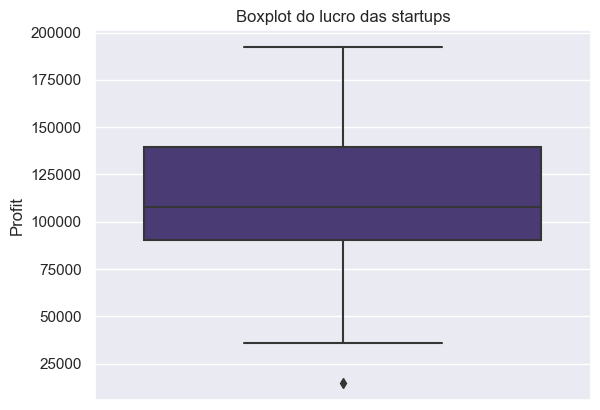

In [18]:
# Analisando o boxplot de profit
fig, ax = plt.subplots()
plt.title('Boxplot do lucro das startups')
sns.boxplot(y=y)

Baseado nos resultados dos testes e das análises gráficas, é prudente assumir que os dados podem seguir distribuição normal. Mesmo assim, os testes serão refeitos para as variáveis transformadas.

### <u>Transformação ln</u>

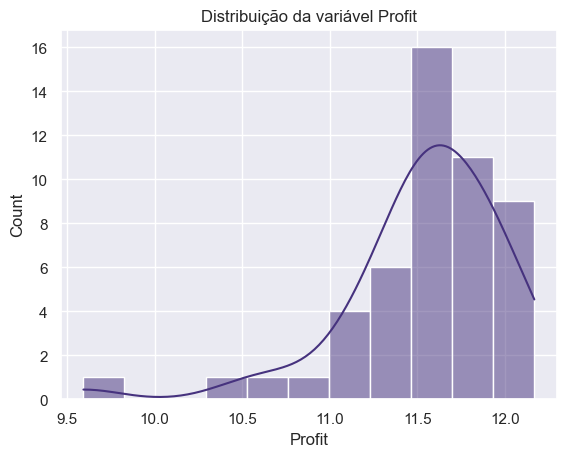

In [19]:
y_ln = np.log(y)

# Distribuição da resposta
plt.title('Distribuição da variável Profit')
sns.histplot(y_ln, kde=True);

In [20]:
# Analise de normalidade pelo método Shapiro-Wilk
print(stats.shapiro(y_ln))

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.anderson(y_ln)}')

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.kstest(y_ln, cdf="norm")}')

ShapiroResult(statistic=0.8665253520011902, pvalue=4.473743319977075e-05)

AndersonResult(statistic=1.3809991101407846, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

KstestResult(statistic=1.0, pvalue=0.0)


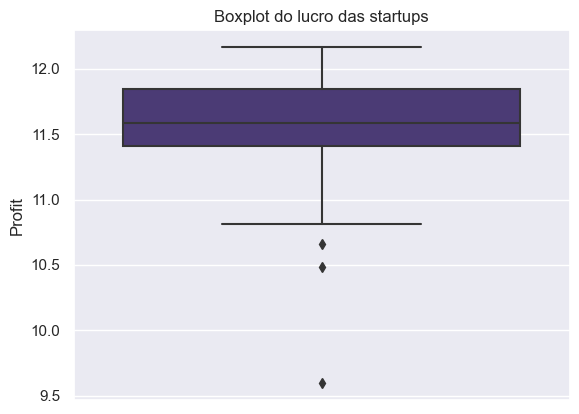

In [21]:
# Analisando o boxplot de profit
fig, ax = plt.subplots()
plt.title('Boxplot do lucro das startups')
sns.boxplot(y=y_ln);

### <u>Transformação 1/y</u>

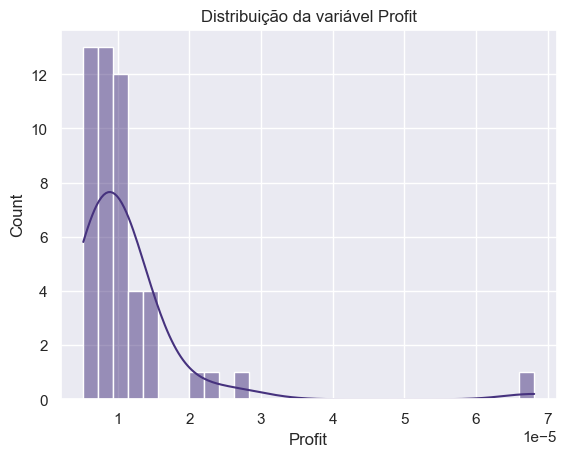

In [22]:
y_inv = 1/y

# Distribuição da resposta
plt.title('Distribuição da variável Profit')
sns.histplot(y_inv, kde=True);

In [23]:
# Analise de normalidade pelo método Shapiro-Wilk
print(stats.shapiro(y_inv))

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.anderson(y_inv)}')

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.kstest(y_inv, cdf="norm")}')

ShapiroResult(statistic=0.4850187301635742, pvalue=5.340565663314312e-12)

AndersonResult(statistic=7.063230191593341, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

KstestResult(statistic=0.5000020749947112, pvalue=4.3918122433080876e-12)


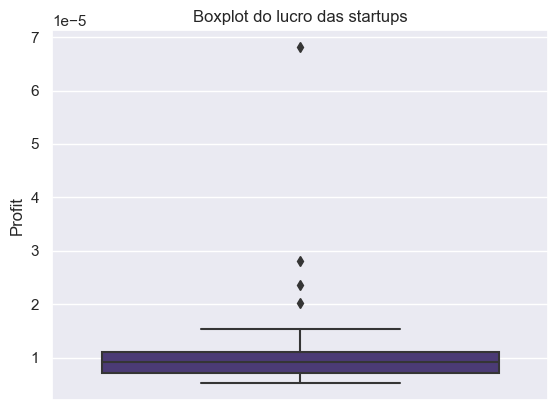

In [24]:
# Analisando o boxplot de profit
fig, ax = plt.subplots()
plt.title('Boxplot do lucro das startups')
sns.boxplot(y=y_inv);

### <u>Transformação $\sqrt{y}$</u>

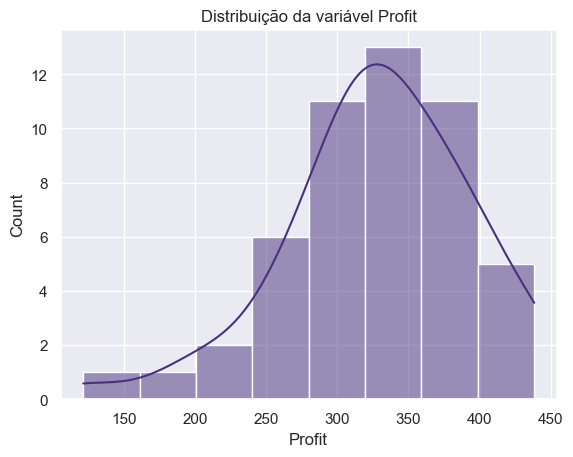

In [25]:
y_sqrt = y ** .5

# Distribuição da resposta
plt.title('Distribuição da variável Profit')
sns.histplot(y_sqrt, kde=True);

In [26]:
# Analise de normalidade pelo método Shapiro-Wilk
print(stats.shapiro(y_sqrt))

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.anderson(y_sqrt)}')

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.kstest(y_sqrt, cdf="norm")}')

ShapiroResult(statistic=0.9628490209579468, pvalue=0.11701814830303192)

AndersonResult(statistic=0.41021400401178454, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

KstestResult(statistic=1.0, pvalue=0.0)


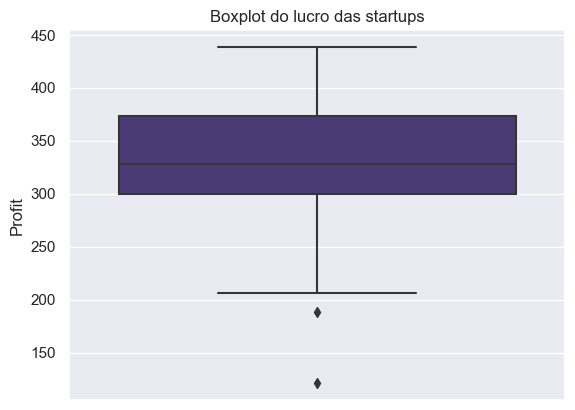

In [27]:
# Analisando o boxplot de profit
fig, ax = plt.subplots()
plt.title('Boxplot do lucro das startups')
sns.boxplot(y=y_sqrt);

### <u>Transformação $\sqrt{1/y}$</u>

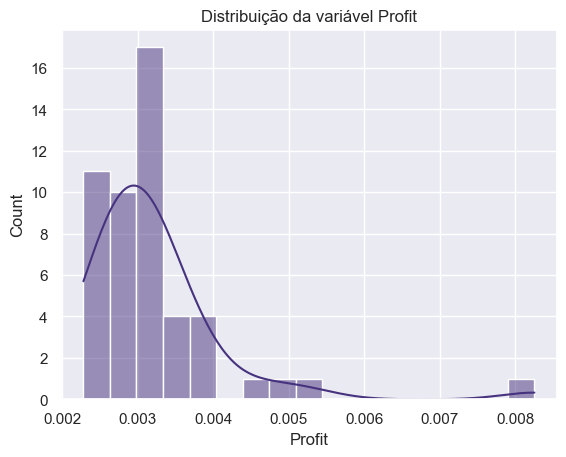

In [28]:
y_sqrt_inv = 1 / (y ** .5)

# Distribuição da resposta
plt.title('Distribuição da variável Profit')
sns.histplot(y_sqrt_inv, kde=True);

In [29]:
# Analise de normalidade pelo método Shapiro-Wilk
print(stats.shapiro(y_sqrt_inv))

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.anderson(y_sqrt_inv)}')

# Análise de normalidade pelo método Anderson-Darling
print(f'\n{stats.kstest(y_sqrt_inv, cdf="norm")}')

ShapiroResult(statistic=0.6879404187202454, pvalue=5.060197150186241e-09)

AndersonResult(statistic=3.6094284029649373, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

KstestResult(statistic=0.5009098360768173, pvalue=3.958676193748014e-12)


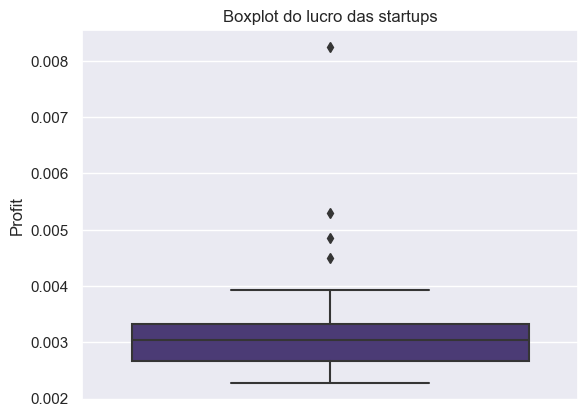

In [30]:
# Analisando o boxplot de profit
fig, ax = plt.subplots()
plt.title('Boxplot do lucro das startups')
sns.boxplot(y=y_sqrt_inv);

Aparentemente, pelas análises gráficas e testes de normalidade, é recomendado permanecer com as variáveis sem a transformação.

In [36]:
X.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York
0,2.016411,0.560753,2.153943,0,0,1
1,1.955860,1.082807,1.923600,1,0,0
2,1.754364,-0.728257,1.626528,0,1,0
3,1.554784,-0.096365,1.422210,0,0,1
4,1.504937,-1.079919,1.281528,0,1,0


# PARTE 2 - Chi Square

## Regressão por mínimos quadrados

### Adição da resposta e alteração dos nomes

In [48]:
# Concatenando os dataframes
df_full = pd.concat([X, y], axis=1)

# Renomeando as colunas
df_full.rename(columns={'R&D Spend': 'rd',
                        'Administration': 'adm',
                        'Marketing Spend': 'mkt',
                        'State_California': 'ca',
                        'State_Florida': 'fl',
                        'State_New York': 'ny'}, inplace=True)

In [49]:
df_full.head()

,rd,adm,mkt,ca,fl,ny,Profit
0,2.016411,0.560753,2.153943,0,0,1,192261.83
1,1.955860,1.082807,1.923600,1,0,0,191792.06
2,1.754364,-0.728257,1.626528,0,1,0,191050.39
3,1.554784,-0.096365,1.422210,0,0,1,182901.99
4,1.504937,-1.079919,1.281528,0,1,0,166187.94


### Escrever a fórmula

In [50]:
def ols_formula(df, dependent_var, *excluded_cols):
    
    # listar o nome das colunas do dataframe
    cols = list(df.columns)
    
    # remover a variavel dependente
    cols.remove(dependent_var)
    
    # remover as variaveis excluidas
    for col in excluded_cols:
        cols.remove(col)
        
    # retornar a fórmula
    return dependent_var + ' ~ ' + ' + '.join(cols)

### Criando a matriz do modelo

In [55]:
y, X = pt.dmatrices(ols_formula(df_full, 'Profit'), data=df_full, return_type='dataframe')

In [56]:
y.head()

,Profit
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


In [57]:
X.head()

,Intercept,rd,adm,mkt,ca,fl,ny
0,1.0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.0,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.0,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.0,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.0,1.504937,-1.079919,1.281528,0.0,1.0,0.0


### Ajuste do modelo

In [58]:
# Especificação do modelo
reg1 = sm.OLS(y, X)

# Ajuste do modelo por mínimos quadrados
reg1fit = reg1.fit()

In [60]:
print(reg1fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Sun, 16 Jul 2023   Prob (F-statistic):           1.34e-27
Time:                        12:49:54   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04   1001.609     83.877      0.0

## Método do gradiente descendente

### Função perda

In [63]:
def perda(X, y, beta):
    '''
    X é a matriz com os regressores (m x n).
    y é a série com as respostas (1 x m).
    beta é a série dos parâmetros (1 x n).
    '''
    
    # Previsão dos valores
    pred = X.dot(beta)
    
    # Calcular os erros de previsão
    res = np.subtract(pred, y.squeeze())
    
    # Calcula o quadrado dos erros
    res_pow2 =  np.square(res)
    
    # Calcula a perda
    perda = 1 / (2*m) * np.sum(res_pow2)
    
    return perda

### Função gradiente descendente

In [84]:
def grad_desc(X, y, beta, alpha, iteracoes):
    '''
    X é a matriz com os regressores (m x n).
    y é a série com as respostas (1 x m).
    beta é a série dos valores iniciais dos parâmetros (1 x n).
    alpha é a taxa de aprendizagem (escalar).
    
    ___________________________________________________________
    Resultados
    
    beta é a série com os valores finais dos parâmetros.
    
    h_perda é a série histórica das perdas.
    '''
    
    # Inicializa a série do histórico de perdas
    h_perda = np.zeros(iteracoes)
    
    for i in range(iteracoes):
        
        # Calcula as previsoes com os valores atuais dos parâmetros 
        pred = X.dot(beta)
        
        # Calcula os resíduos das previsões
        res =  np.subtract(pred, y.squeeze())
        
        # Calcula o incremento / decremento dos betas - derivada parcial da função perda
        sum_delta = (alpha / m ) *  X.transpose().dot(res)
        
        # Atualizar os valores dos betas do modelo
        beta = beta - sum_delta
        
        # Calcula a nova perda com os novos valores de beta
        h_perda[i] = perda(X, y, beta)
            
    return beta, h_perda

### Aplicação do algoritmo de gradiente descendente

#### Setup do algoritmo

In [96]:
# Salvar o tamanho do dataframe com os regressores (incluindo o intercept)
m, n = X.shape

# Inicializar a série de betas
beta = np.zeros(n)

# Definindo Iterações
iteracoes = 1000

# Definindo valor de alpha
alpha = 0.01

#### Aplicando o algoritmo

In [97]:
beta, h_perda = grad_desc(X, y, beta, alpha, iteracoes)

In [98]:
beta

Intercept    84003.338064
rd           34823.767133
adm           -115.735058
mkt           5033.523749
ca           28046.579506
fl           27659.265108
ny           28297.493449
dtype: float64

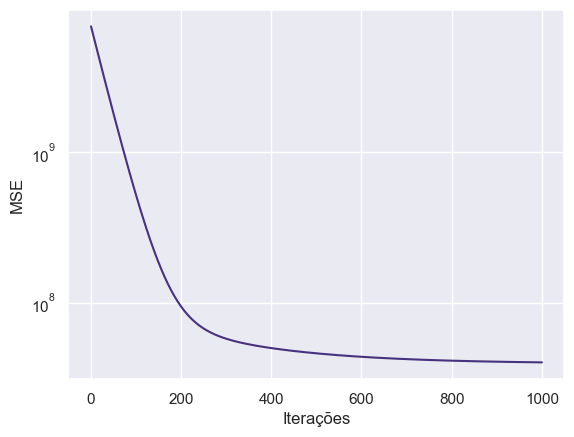

In [100]:
# Estudo de convergência
fig = plt.figure()
plt.semilogy(range(1, iteracoes+1), h_perda) 
plt.ylabel('MSE')
plt.xlabel('Iterações')
plt.title('P')
plt.show()